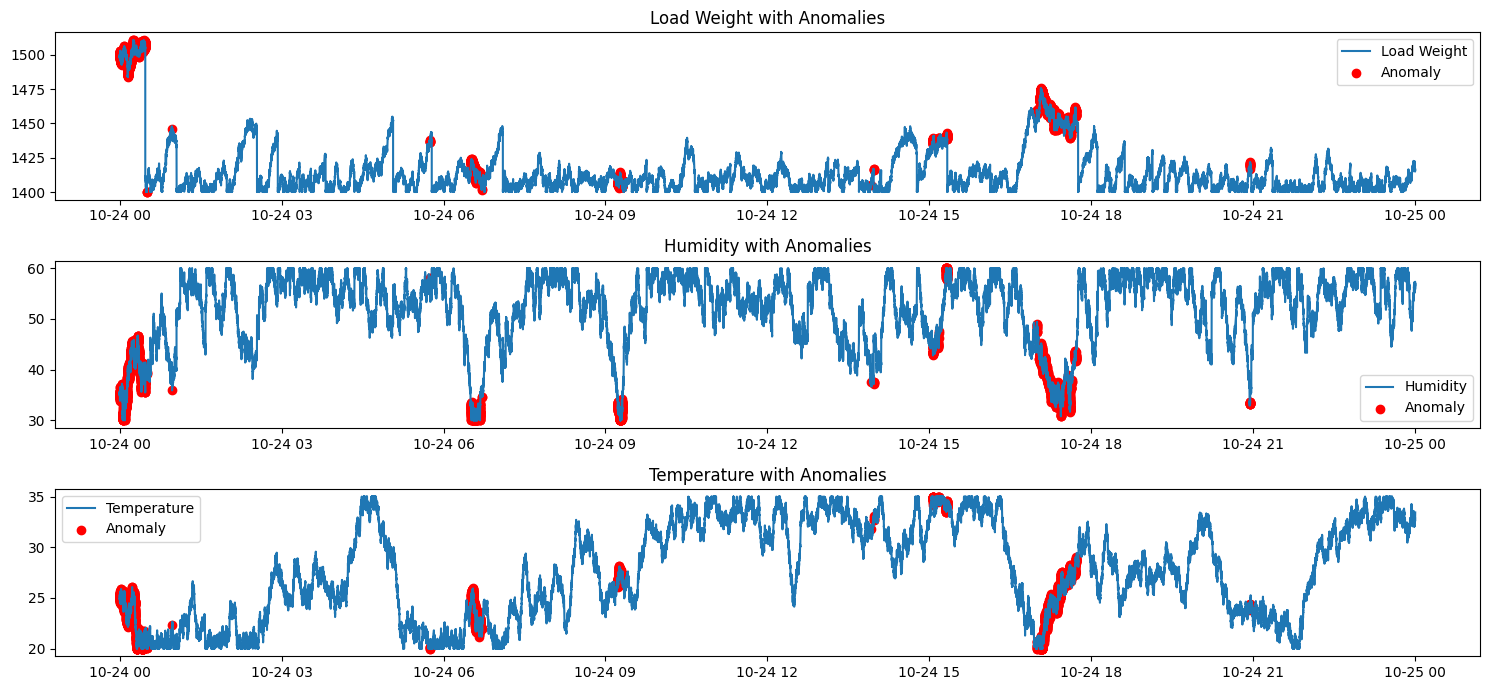

Detected anomalies:
                           load_weight  humidity  temperature
timestamp                                                    
2024-10-24 00:00:00+00:00      1499.85     35.21        24.88
2024-10-24 00:00:01+00:00      1500.19     35.22        24.87
2024-10-24 00:00:02+00:00      1499.58     35.10        25.05
2024-10-24 00:00:03+00:00      1499.60     35.57        25.12
2024-10-24 00:00:04+00:00      1498.90     35.35        25.01
...                                ...       ...          ...
2024-10-24 20:56:26+00:00      1420.19     33.29        24.16
2024-10-24 20:56:27+00:00      1419.33     33.49        24.29
2024-10-24 20:56:28+00:00      1418.84     33.44        24.11
2024-10-24 20:56:29+00:00      1418.72     33.21        24.29
2024-10-24 20:56:30+00:00      1419.70     33.50        24.31

[4320 rows x 3 columns]


In [2]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import json

# Step 1: Load data from JSON file
with open(r'D:\Codeutsav\dead\sensor_data_route_jk_to_chennai.json') as f:
    data = json.load(f)

# Step 2: Convert to DataFrame
df = pd.DataFrame(data)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set the index to the timestamp
df.set_index('timestamp', inplace=True)

# Step 3: Extract features for anomaly detection
features = df[['load_weight', 'humidity', 'temperature']]

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)

# Fit the model
model.fit(features)

# Predict anomalies
df['anomaly'] = model.predict(features)

# Anomalies are marked as -1
anomalies = df[df['anomaly'] == -1]

# Plotting the results
plt.figure(figsize=(15, 7))

# Plot load_weight
plt.subplot(3, 1, 1)
plt.plot(df.index, df['load_weight'], label='Load Weight')
plt.scatter(anomalies.index, anomalies['load_weight'], color='red', label='Anomaly', marker='o')
plt.title('Load Weight with Anomalies')
plt.legend()

# Plot humidity
plt.subplot(3, 1, 2)
plt.plot(df.index, df['humidity'], label='Humidity')
plt.scatter(anomalies.index, anomalies['humidity'], color='red', label='Anomaly', marker='o')
plt.title('Humidity with Anomalies')
plt.legend()

# Plot temperature
plt.subplot(3, 1, 3)
plt.plot(df.index, df['temperature'], label='Temperature')
plt.scatter(anomalies.index, anomalies['temperature'], color='red', label='Anomaly', marker='o')
plt.title('Temperature with Anomalies')
plt.legend()

plt.tight_layout()
plt.show()

# Output anomalies
print("Detected anomalies:")
print(anomalies[['load_weight', 'humidity', 'temperature']])

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Load the data
df = pd.read_csv(r'D:\Codeutsav\dead\truck_sensor_data_with_random_anomalies.csv', parse_dates=['Timestamp'])

# Extract features
features = ['Weight', 'Moisture', 'Temperature']
X = df[features].values

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 50
X_seq = create_sequences(X_scaled, seq_length)

# Prepare data for LSTM
X_train = torch.FloatTensor(X_seq[:-1])
y_train = torch.FloatTensor(X_seq[1:, -1, :])

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
input_size = len(features)
hidden_size = 16
num_layers = 3
output_size = len(features)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(num_epochs)):
    loss_ = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss_ += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Loss is {loss_}")
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Predict on the entire dataset
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_seq).to(device)
    predictions = model(X_test).cpu().numpy()

# Calculate Mean Squared Error
mse = np.mean(np.power(X_seq[:, -1, :] - predictions, 2), axis=1)

# Set threshold for anomaly detection (e.g., 95th percentile of MSE)
threshold = np.percentile(mse, 95)

# Detect anomalies
anomalies = mse > threshold

# Add predictions and anomaly detection results to the dataframe
df['predicted_anomaly'] = 0
df.loc[seq_length-1:, 'predicted_anomaly'] = anomalies.astype(int)

# Compare with original anomaly column
accuracy = np.mean(df['anomaly'] == df['predicted_anomaly'])
print(f"Accuracy: {accuracy:.2f}")

# Print rows where anomalies were detected
print(df[df['predicted_anomaly'] == 1])

  2%|▏         | 1/50 [02:41<2:11:45, 161.35s/it]

Loss is 338.36238805623725


  4%|▍         | 2/50 [05:32<2:13:42, 167.14s/it]

Loss is 330.8709544413723


  6%|▌         | 3/50 [08:16<2:09:49, 165.74s/it]

Loss is 330.78370235674083


  8%|▊         | 4/50 [10:44<2:01:36, 158.62s/it]

Loss is 330.75836152164266


 10%|█         | 5/50 [13:06<1:54:25, 152.58s/it]

Loss is 330.7170480149798


 12%|█▏        | 6/50 [16:20<2:02:12, 166.64s/it]

Loss is 330.7088611610234


 14%|█▍        | 7/50 [19:27<2:04:18, 173.45s/it]

Loss is 330.6961466805078


 16%|█▌        | 8/50 [21:53<1:55:14, 164.63s/it]

Loss is 330.65676737297326


 18%|█▊        | 9/50 [24:18<1:48:26, 158.68s/it]

Loss is 330.6585165858269


 20%|██        | 10/50 [26:54<1:45:13, 157.84s/it]

Loss is 330.6241903267801
Epoch [10/50], Loss: 0.0116


 22%|██▏       | 11/50 [29:21<1:40:17, 154.30s/it]

Loss is 330.6194955166429


 24%|██▍       | 12/50 [31:48<1:36:19, 152.09s/it]

Loss is 330.6196423433721


 26%|██▌       | 13/50 [34:40<1:37:31, 158.16s/it]

Loss is 330.6117811566219


 28%|██▊       | 14/50 [37:13<1:33:57, 156.61s/it]

Loss is 330.60231843777


 30%|███       | 15/50 [39:49<1:31:15, 156.44s/it]

Loss is 330.6072530057281


 32%|███▏      | 16/50 [42:32<1:29:43, 158.33s/it]

Loss is 330.5898797819391


 34%|███▍      | 17/50 [45:05<1:26:17, 156.88s/it]

Loss is 330.60382657824084


 36%|███▌      | 18/50 [47:38<1:23:03, 155.72s/it]

Loss is 330.5933536575176


 38%|███▊      | 19/50 [50:11<1:19:58, 154.78s/it]

Loss is 330.5855994010344


 40%|████      | 20/50 [52:44<1:17:06, 154.22s/it]

Loss is 330.5887927659787
Epoch [20/50], Loss: 0.0093


 42%|████▏     | 21/50 [55:15<1:14:09, 153.43s/it]

Loss is 330.57628695992753


 44%|████▍     | 22/50 [57:47<1:11:20, 152.88s/it]

Loss is 330.58049433957785


 46%|████▌     | 23/50 [1:00:19<1:08:38, 152.53s/it]

Loss is 330.5733405086212


 48%|████▊     | 24/50 [1:02:51<1:06:05, 152.52s/it]

Loss is 330.5785409803502


 50%|█████     | 25/50 [1:05:19<1:02:56, 151.05s/it]

Loss is 330.57264820253477


 52%|█████▏    | 26/50 [1:07:50<1:00:26, 151.11s/it]

Loss is 330.583610100206


 54%|█████▍    | 27/50 [1:10:22<58:01, 151.39s/it]  

Loss is 330.5798177802935


 56%|█████▌    | 28/50 [1:12:53<55:26, 151.19s/it]

Loss is 330.5868412167765


 58%|█████▊    | 29/50 [1:15:24<52:52, 151.08s/it]

Loss is 330.57660638261586


 60%|██████    | 30/50 [1:17:39<48:50, 146.51s/it]

Loss is 330.5813377732411
Epoch [30/50], Loss: 0.0112


 62%|██████▏   | 31/50 [1:19:56<45:28, 143.60s/it]

Loss is 330.5728088328615


 64%|██████▍   | 32/50 [1:22:03<41:32, 138.47s/it]

Loss is 330.57754755718634


 66%|██████▌   | 33/50 [1:24:09<38:12, 134.87s/it]

Loss is 330.57635169196874


 68%|██████▊   | 34/50 [1:26:16<35:17, 132.37s/it]

Loss is 330.57760188914835


 70%|███████   | 35/50 [1:28:22<32:38, 130.59s/it]

Loss is 330.5845817816444


 72%|███████▏  | 36/50 [1:30:28<30:10, 129.32s/it]

Loss is 330.5692948307842


 74%|███████▍  | 37/50 [1:32:35<27:49, 128.43s/it]

Loss is 330.58121610991657


 76%|███████▌  | 38/50 [1:34:41<25:33, 127.83s/it]

Loss is 330.5758813191205


 78%|███████▊  | 39/50 [1:36:47<23:20, 127.33s/it]

Loss is 330.58088429272175


 80%|████████  | 40/50 [1:38:54<21:10, 127.07s/it]

Loss is 330.57031234772876
Epoch [40/50], Loss: 0.0115


 82%|████████▏ | 41/50 [1:41:00<19:01, 126.80s/it]

Loss is 330.5654969862662


 84%|████████▍ | 42/50 [1:43:07<16:53, 126.72s/it]

Loss is 330.5806939783506


 86%|████████▌ | 43/50 [1:45:13<14:46, 126.68s/it]

Loss is 330.57367554772645


 88%|████████▊ | 44/50 [1:47:20<12:40, 126.69s/it]

Loss is 330.5787108838558


 90%|█████████ | 45/50 [1:49:27<10:33, 126.75s/it]

Loss is 330.57763014920056


 92%|█████████▏| 46/50 [1:51:33<08:26, 126.69s/it]

Loss is 330.56671888940036


 94%|█████████▍| 47/50 [1:53:41<06:20, 126.92s/it]

Loss is 330.57400575326756


 96%|█████████▌| 48/50 [1:55:47<04:13, 126.69s/it]

Loss is 330.5739325527102


 98%|█████████▊| 49/50 [1:57:53<02:06, 126.37s/it]

Loss is 330.5738543565385


100%|██████████| 50/50 [1:59:59<00:00, 143.99s/it]

Loss is 330.5807977053337
Epoch [50/50], Loss: 0.0115


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.61 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 4.83 GiB is allocated by PyTorch, and 78.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

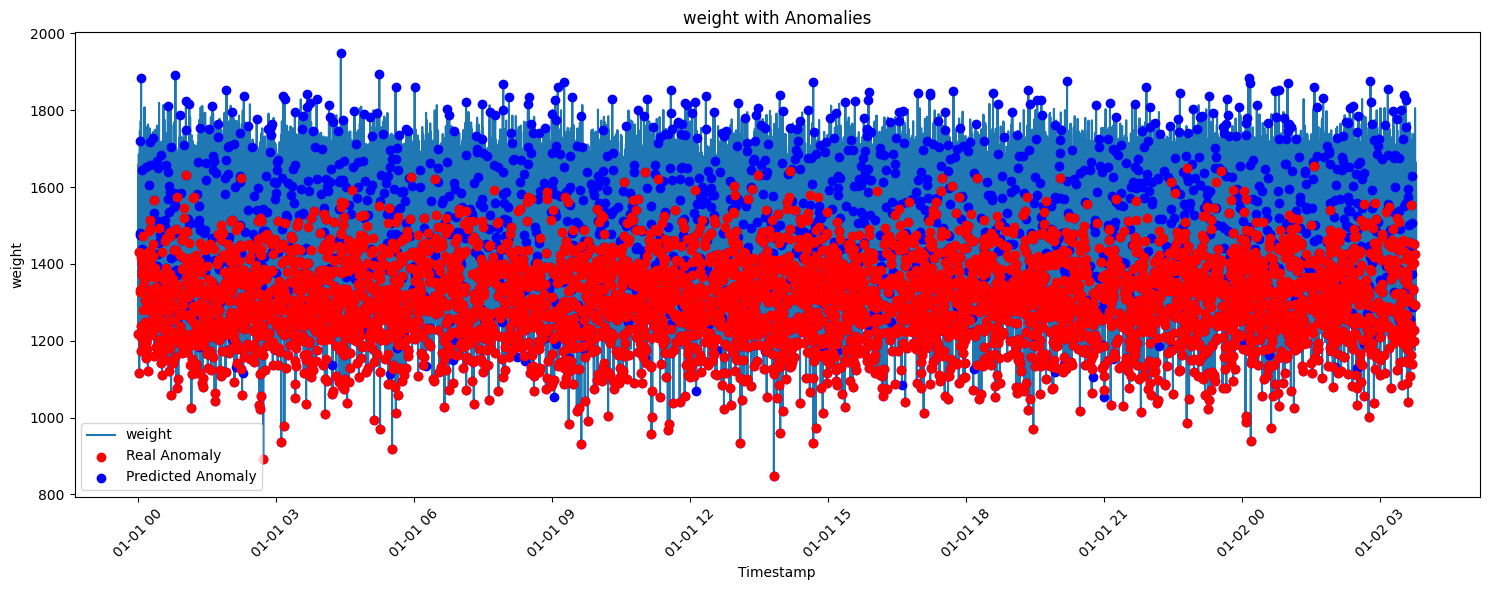

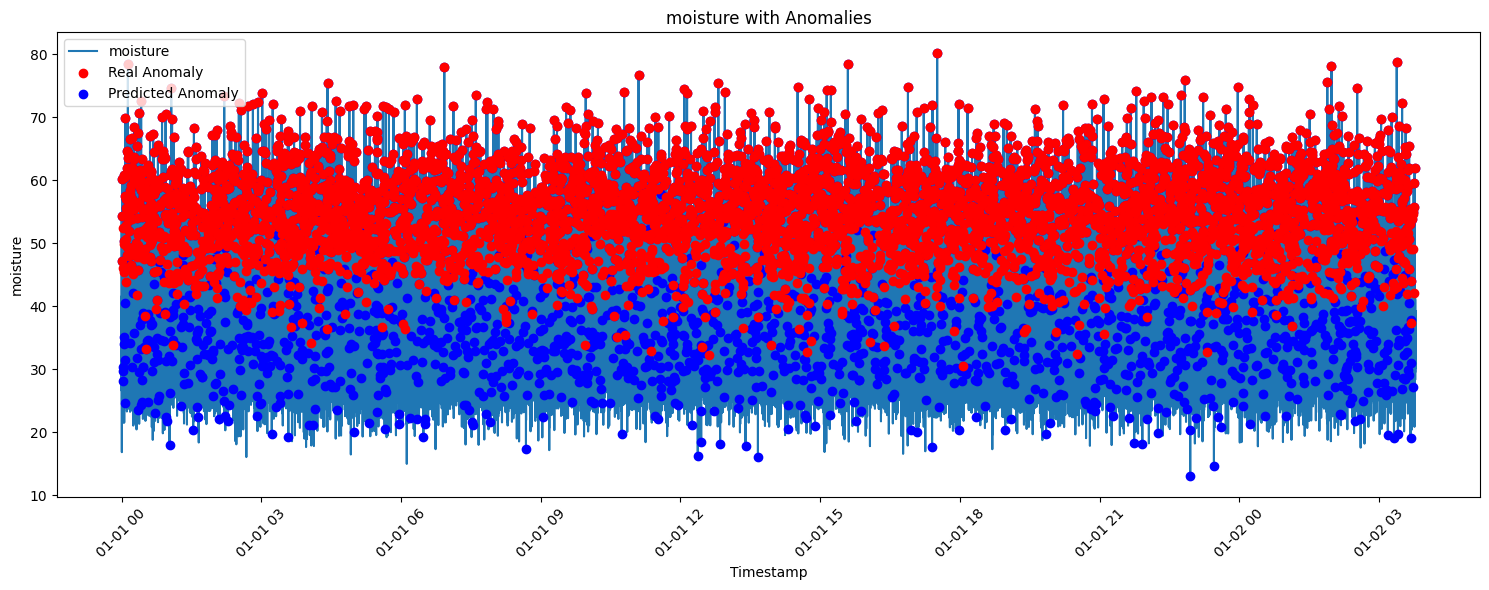

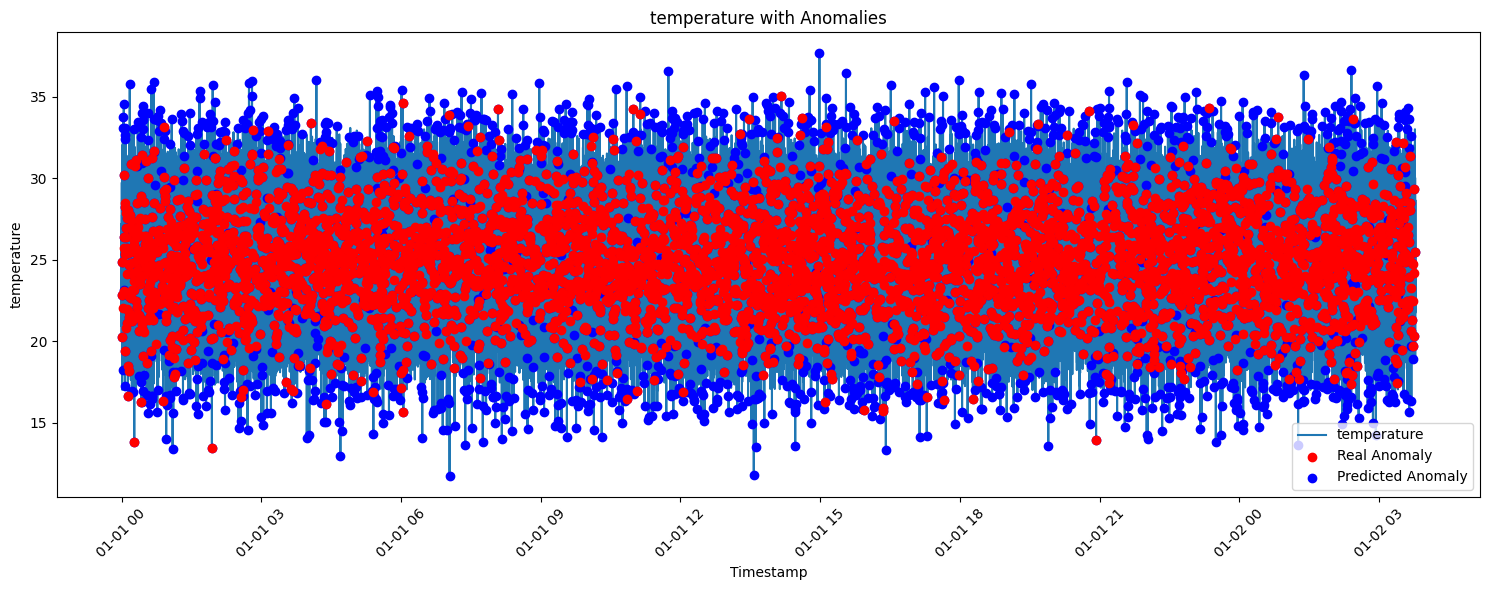

Precision: 0.69
Recall: 0.69
F1-score: 0.69

Confusion Matrix:
Predicted      0     1
Actual                
0.0        93454  1546
1.0         1546  3454


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def plot_results(df, feature, real_anomalies, predicted_anomalies):
    plt.figure(figsize=(15, 6))
    plt.plot(df['timestamp'], df[feature], label=feature)
    
    # Plot real anomalies
    real_anomaly_points = df[df['anomaly'] == 1]
    plt.scatter(real_anomaly_points['timestamp'], real_anomaly_points[feature], 
                color='red', label='Real Anomaly', zorder=5)
    
    # Plot predicted anomalies
    predicted_anomaly_points = df[df['predicted_anomaly'] == 1]
    plt.scatter(predicted_anomaly_points['timestamp'], predicted_anomaly_points[feature], 
                color='blue', label='Predicted Anomaly', zorder=4)
    
    plt.title(f'{feature} with Anomalies')
    plt.xlabel('Timestamp')
    plt.ylabel(feature)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot results for each feature
for feature in features:
    plot_results(df, feature, df['anomaly'], df['predicted_anomaly'])

# Calculate and print metrics
true_positives = ((df['anomaly'] == 1) & (df['predicted_anomaly'] == 1)).sum()
false_positives = ((df['anomaly'] == 0) & (df['predicted_anomaly'] == 1)).sum()
false_negatives = ((df['anomaly'] == 1) & (df['predicted_anomaly'] == 0)).sum()

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(pd.crosstab(df['anomaly'], df['predicted_anomaly'], rownames=['Actual'], colnames=['Predicted']))

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time

# Assuming you've already trained and saved the model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Load the trained model
input_size = 3  # weight, moisture, temperature
hidden_size = 64
num_layers = 2
output_size = 3

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('lstm_model.pth'))
model.eval()

# Load the scaler used during training
scaler = MinMaxScaler()
scaler.min_ = np.load('scaler_min.npy')
scaler.scale_ = np.load('scaler_scale.npy')

# Parameters
seq_length = 5
features = ['weight', 'moisture', 'temperature']
anomaly_threshold = 0.1  # Adjust based on your needs

# Initialize a buffer to store recent data points
data_buffer = []

def detect_anomaly(new_data):
    global data_buffer
    
    # Add new data to the buffer
    data_buffer.append(new_data)
    
    # Keep only the most recent seq_length data points
    if len(data_buffer) > seq_length:
        data_buffer = data_buffer[-seq_length:]
    
    # If we don't have enough data points yet, return None
    if len(data_buffer) < seq_length:
        return None
    
    # Prepare the data for the model
    X = np.array(data_buffer)
    X_scaled = scaler.transform(X)
    X_tensor = torch.FloatTensor(X_scaled).unsqueeze(0)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        prediction = model(X_tensor).numpy()
    
    # Compare prediction with actual (last point in sequence)
    actual = X_scaled[-1]
    mse = np.mean((actual - prediction[0])**2)
    
    # Detect anomaly
    is_anomaly = mse > anomaly_threshold
    
    return is_anomaly, mse

# Simulated data stream
def data_stream():
    while True:
        # In a real scenario, this would be your data source (e.g., sensor readings)
        weight = np.random.normal(1500, 100)
        moisture = np.random.normal(35, 5)
        temperature = np.random.normal(25, 3)
        
        yield [weight, moisture, temperature]
        time.sleep(1)  # Simulate 1 second between readings

# Main inference loop
for data in data_stream():
    result = detect_anomaly(data)
    if result is not None:
        is_anomaly, mse = result
        print(f"Data: {data}")
        print(f"Anomaly: {is_anomaly}, MSE: {mse:.4f}")
        print("--------------------")


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Parameters
num_samples = 100000  # Total number of data points
initial_weight = 15000  # Initial weight of coal in kg
initial_temperature = 31  # Initial temperature in Celsius
initial_humidity = 72.3  # Initial humidity in percentage
anomaly_start = 15000  # Start index for anomaly simulation
anomaly_duration = 5000  # Duration of the anomaly in samples
jerk_probability = 0.01  # Probability of a jerk occurring at any given sample
jerk_magnitude = 10  # Magnitude of the jerk (in kg)

# Lists to hold data
timestamps = []
weights = []
temperatures = []
humidities = []
anomalies = []

# Generate timestamps
start_time = datetime.now()
for i in range(num_samples):
    timestamps.append(start_time + timedelta(minutes=i))

    # Normal conditions
    weight = initial_weight + np.random.normal(0, 5)  # Normal fluctuations
    temperature = initial_temperature + np.random.normal(0, 0.02)  # Minor fluctuations
    humidity = initial_humidity + np.random.normal(0, 0.02)  # Minor fluctuations
    anomaly_label = 0  # Normal condition

    # Simulate theft conditions
    if i >= anomaly_start and i < anomaly_start + anomaly_duration:
        # Keep weight relatively constant while simulating water addition
        # weight = initial_weight + np.random.normal(0, 8)  # Slight fluctuations around the initial weight
        humidity += np.random.uniform(0,0.007)  # Random increase or decrease in humidity
        temperature -= np.random.uniform(0,0.005)  # Random increase or decrease in temperature
        anomaly_label = 1  # Anomaly condition
        # # initial_weight = weight
    if np.random.rand() < jerk_probability:  # Randomly decide if a jerk occurs
        jerk_direction = np.random.choice([-1, 1])  # Randomly choose direction of the jerk
        weight += jerk_direction * jerk_magnitude  # Apply the jerk
    initial_temperature = temperature
    initial_humidity = humidity

    # Append data
    weights.append(weight)
    temperatures.append(temperature)
    humidities.append(humidity)
    anomalies.append(anomaly_label)

# Create DataFrame
data = {
    'Timestamp': timestamps,
    'Weight (kg)': weights,
    'Temperature (°C)': temperatures,
    'Humidity (%)': humidities,
    'Anomaly Label': anomalies
}

df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())

# Optionally, save the DataFrame to a CSV file
# df.to_csv('train.csv', index=False)

                   Timestamp   Weight (kg)  Temperature (°C)  Humidity (%)  \
0 2024-10-27 11:06:45.080539  14999.165966         31.036545     72.317877   
1 2024-10-27 11:07:45.080539  15000.721554         31.046589     72.308663   
2 2024-10-27 11:08:45.080539  15000.560504         31.064658     72.306214   
3 2024-10-27 11:09:45.080539  15002.788119         31.064502     72.308278   
4 2024-10-27 11:10:45.080539  14998.075501         31.078189     72.301771   

   Anomaly Label  
0              0  
1              0  
2              0  
3              0  
4              0  


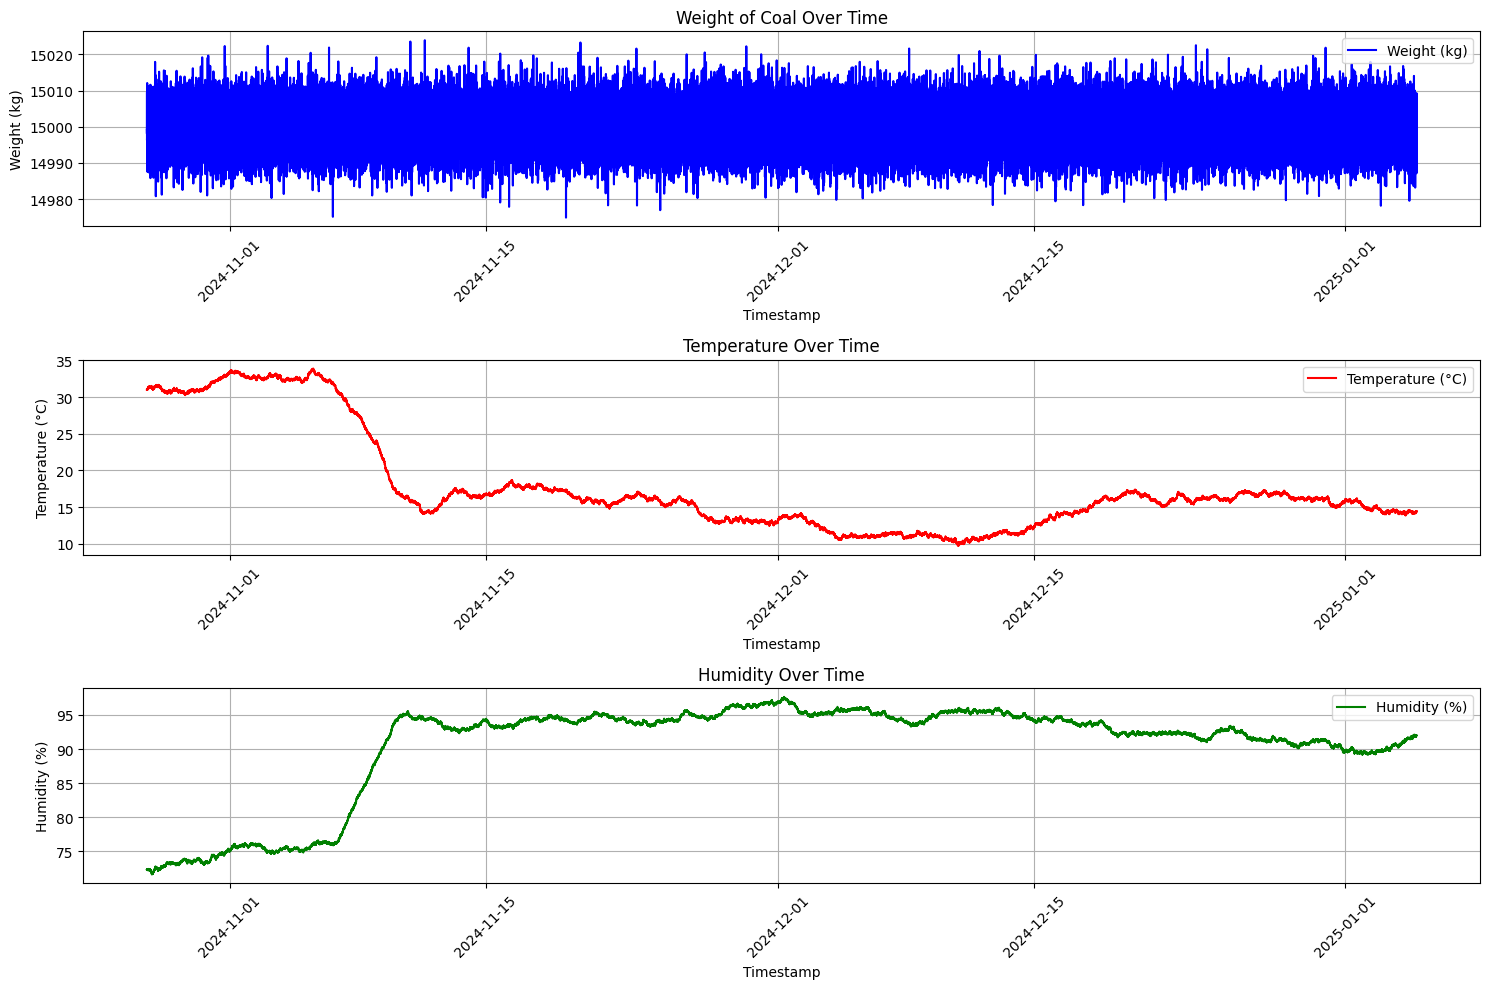

In [12]:
# Plotting the data
plt.figure(figsize=(15, 10))

# Plot Weight
plt.subplot(3, 1, 1)
plt.plot(df['Timestamp'], df['Weight (kg)'], color='blue', label='Weight (kg)')
plt.title('Weight of Coal Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Weight (kg)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

# Plot Temperature
plt.subplot(3, 1, 2)
plt.plot(df['Timestamp'], df['Temperature (°C)'], color='red', label='Temperature (°C)')
plt.title('Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(df['Timestamp'], df['Humidity (%)'], color='green', label='Humidity (%)')
plt.title('Humidity Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Humidity (%)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [138]:
print(min(df["Temperature (°C)"])-max(df["Temperature (°C)"]))
print(print(min(df["Humidity (%)"])-max(df["Humidity (%)"])))

-0.6256197256471907
-0.5364896471851779
None


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Load data from a stream (here, placeholder data is used)
# data = pd.read_csv('your_data_file.csv') # Use this if reading from a CSV file
# Assuming `data` has columns 'timestamp', 'humidity', and 'temperature'

# Placeholder: Replace with actual streaming data load process
# timestamps = np.arange(100000)
# humidity = np.random.normal(loc=75, scale=5, size=100000)
# temperature = np.random.normal(loc=25, scale=3, size=100000)
data = pd.read_csv(r"D:\Codeutsav\dead\synthetic_.csv")

# Parameters for anomaly detection
ROLLING_WINDOW = 1000  # Size of rolling window
Z_SCORE_THRESHOLD = 5  # Z-score threshold for anomaly detection

# Calculate rolling mean and std for humidity and temperature
data['humidity_mean'] = data['Humidity (%)'].rolling(window=ROLLING_WINDOW).mean()
data['humidity_std'] = data['Humidity (%)'].rolling(window=ROLLING_WINDOW).std()
data['temperature_mean'] = data['Temperature (°C)'].rolling(window=ROLLING_WINDOW).mean()
data['temperature_std'] = data['Temperature (°C)'].rolling(window=ROLLING_WINDOW).std()

# Calculate z-scores for humidity and temperature deviations
data['humidity_zscore'] = (data['Humidity (%)'] - data['humidity_mean']) / data['humidity_std']
data['temperature_zscore'] = (data['Temperature (°C)'] - data['temperature_mean']) / data['temperature_std']

# Flag anomalies based on z-score threshold
data['humidity_anomaly'] = data['humidity_zscore'].abs() > Z_SCORE_THRESHOLD
data['temperature_anomaly'] = data['temperature_zscore'].abs() > Z_SCORE_THRESHOLD

# Filter anomalies
humidity_anomalies = data[data['humidity_anomaly']]
temperature_anomalies = data[data['temperature_anomaly']]

# Print anomaly summary
print("Humidity anomalies detected:", len(humidity_anomalies))
print("Temperature anomalies detected:", len(temperature_anomalies))

# Visualize anomalies
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14, 6))

# # Plot humidity with anomalies
# plt.subplot(2, 1, 1)
# plt.plot(data['Timestamp'], data['Humidity (%)'], label='Humidity', color='lightgreen')
# plt.scatter(humidity_anomalies['Timestamp'], humidity_anomalies['Humidity (%)'], color='blue', label='Humidity Anomalies')
# plt.xlabel('Timestamp')
# plt.ylabel('Humidity (%)')
# plt.title('Humidity with Anomalies')
# plt.legend()

# # Plot temperature with anomalies
# plt.subplot(2, 1, 2)
# plt.plot(data['Timestamp'], data['Temperature (°C)'], label='Temperature', color='lightcoral')
# plt.scatter(temperature_anomalies['Timestamp'], temperature_anomalies['Temperature (°C)'], color='red', label='Temperature Anomalies')
# plt.xlabel('Timestamp')
# plt.ylabel('Temperature (°C)')
# plt.title('Temperature with Anomalies')
# plt.legend()

# plt.tight_layout()
# plt.show()


Humidity anomalies detected: 0
Temperature anomalies detected: 0


In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import json
import os

app = Flask(__name__)

# Parameters
ROLLING_WINDOW = 1000
Z_SCORE_THRESHOLD = 5

# Load or Initialize Model Parameters
model_params_file = "model_params.json"

# Load precomputed model parameters if they exist
if os.path.exists(model_params_file):
    with open(model_params_file, 'r') as f:
        model_params = json.load(f)
else:
    model_params = {
        "humidity_mean": None,
        "humidity_std": None,
        "temperature_mean": None,
        "temperature_std": None
    }

# Training function to establish baseline
def train_model(data):
    data['humidity_mean'] = data['Humidity (%)'].rolling(window=ROLLING_WINDOW).mean()
    data['humidity_std'] = data['Humidity (%)'].rolling(window=ROLLING_WINDOW).std()
    data['temperature_mean'] = data['Temperature (°C)'].rolling(window=ROLLING_WINDOW).mean()
    data['temperature_std'] = data['Temperature (°C)'].rolling(window=ROLLING_WINDOW).std()
    
    # Save the last values from rolling calculations as baseline
    model_params['humidity_mean'] = data['humidity_mean'].iloc[-1]
    model_params['humidity_std'] = data['humidity_std'].iloc[-1]
    model_params['temperature_mean'] = data['temperature_mean'].iloc[-1]
    model_params['temperature_std'] = data['temperature_std'].iloc[-1]
    
    # Save model parameters to file
    with open(model_params_file, 'w') as f:
        json.dump(model_params, f)

    print("Model training complete and parameters saved.")

# Endpoint to train the model with historical data
@app.route('/train', methods=['POST'])
def train():
    # Receive training data as JSON
    data = pd.DataFrame(request.json)
    train_model(data)
    return jsonify({"message": "Training complete and model parameters updated."}), 200

# Endpoint to detect anomalies in streaming data
@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    
    humidity = data['humidity']
    temperature = data['temperature']
    
    # Calculate z-scores using baseline model parameters
    humidity_zscore = abs((humidity - model_params['humidity_mean']) / model_params['humidity_std'])
    temperature_zscore = abs((temperature - model_params['temperature_mean']) / model_params['temperature_std'])
    
    # Check for anomalies
    humidity_anomaly = humidity_zscore > Z_SCORE_THRESHOLD
    temperature_anomaly = temperature_zscore > Z_SCORE_THRESHOLD
    
    result = {
        "humidity_anomaly": humidity_anomaly,
        "temperature_anomaly": temperature_anomaly,
    }
    
    return jsonify(result), 200

if __name__ == '__main__':
    app.run(debug=True)
